
# In Context Learning
In this workshop you will test LLM's ability to learn a SSRT task without plasticity (i.e. without updating the weights) using In Conext Learning.

Based on a research project by the amazing Gili Lior & co.

Your code should:
1. Build a SSRT DFA using DFA_utils.py provided to you
2. Generate the full learning prompt (containing both random sequences and sequences generated by the DFA)
3. Load the pre-trained LLM (GPT2 or LlaMA2) and tokenizer from HuggingFace transformers library
4. Generate the model's response to the prompt
5. Calculate the mean probabilities of the sequences - both true (given by the DFA) and those predicted by the model
6. Plot those probabilities to evaluate if and how well the model managed to learn the DFA

Set up the environment

In [1]:
!pip install -q transformers

Some useful constants (you can experiment with the number of epochs if you want).

Number of epochs is referring to the number of sequences in each part of the prompt.

In [41]:
NUM_RANDOM_EPOCHS = 20
NUM_LEARNING_EPOCHS = 60
SEQUENCE_LENGTH = 8

Build a DFA using `build_srtt_dfa` function from DFA_utils.py

In [3]:
from DFA_utils import *

srtt_dfa = build_srtt_dfa(tokens_list_srtt)

This function generates as sequence from a DFA given its start node, and returns both the sequence itself and a dictionary mapping the probability of each token in the sequence according to the transition probabilities of the DFA.

Note: each sequence starts with a SEP_TOKEN.

In [29]:
def generate_sequence_from_dfa(start_node):
  node = start_node
  sequence = [SEP_TOKEN]
  df_probs = [1.0]
  while node.id != END_NODE_ID:
    df_probs.append(1 / len(node.transitions))
    transition = random.choice(node.transitions)
    sequence.append(transition.word)
    node = transition.next_node
  for token in ["START", "END"]:
    if token in sequence:
      df_probs.pop(sequence.index(token))
      sequence.remove(token)
  return sequence, df_probs

This function generates random sequences of given length over a specified vocabulary, and returns a list of these sequences and a list of the probabilities of each token in each sequence. Each sequence ends with a SEP_TOKEN to seperate between them.

Note: random here means uniform distrubtion over the tokens in the vocabulary (i.e. each token should have the same probability).


In [27]:
def generate_random_sequences(seq_length, vocabulary, num_sequences_to_generate):
  token_prob = 1 / len(vocabulary)
  random_probs = [token_prob] * (seq_length + 1) * num_sequences_to_generate
  random_sequences = []
  for _ in range(num_sequences_to_generate):
      sequence = random.choices(vocabulary, k=seq_length)
      sequence.insert(0, SEP_TOKEN)
      random_sequences += sequence
  return random_sequences, random_probs

Implement a function that generates a full In-Context learning prompt consisting of: random sequences + DFA sequences + random sequences; using the functions `generate_random_sequences` and `generate_sequence_from_dfa` provided above.

Your function should return a string representing the full prompt, and the a list containing the true probability of each token in prompt.

Note: `random_epochs` referes to the number of sequences in the each random part, and `learning_epochs` refers to the number of DFA sequences.

In [30]:
def generate_full_prompt(vocabulary, random_epochs, learning_epochs, start_node):
  structure_sequences = []
  structure_probs = []
  for _ in range(learning_epochs):
      sequence, probs = generate_sequence_from_dfa(start_node)
      structure_sequences += sequence
      structure_probs += probs

  prefix_random, prefix_probs = generate_random_sequences(SEQUENCE_LENGTH, vocabulary, random_epochs)
  suffix_random, suffix_probs = generate_random_sequences(SEQUENCE_LENGTH, vocabulary, random_epochs)

  full_prompt = prefix_random + structure_sequences + suffix_random
  full_prompt_probs = prefix_probs + structure_probs + suffix_probs
  full_prompt_str = " ".join(full_prompt)
  return full_prompt_str, full_prompt_probs

Use your function to generate a prompt with the vocabulary of the DFA.

In [42]:
vocabulary = ["blue", "orange", "red", "green"]
full_prompt, true_probs = generate_full_prompt(vocabulary, NUM_RANDOM_EPOCHS, NUM_LEARNING_EPOCHS, srtt_dfa)

Load a pre-trained LLM - either `gpt2` or `meta-llama/Llama-2-7b-hf` from HuggingFace transformers library using the `from_pretrained` function as well as its matching tokenizer.

Note: if you want to use Llama2 you need to pass your HuggingFace token to the `from_pretrained` function.

In [8]:
import numpy as np
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM


TOKEN = '<YOUR_HUGGINFACE_TOKEN>'
model_name = "gpt2"


def get_model(model_name):
    """
    Loads a model and it's matching tokenizer according to model name.
    """
    if model_name == 'gpt2':
        tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        model = GPT2LMHeadModel.from_pretrained('gpt2')
    elif model_name == 'llama':
        model_name = "meta-llama/Llama-2-7b-hf"
        tokenizer = AutoTokenizer.from_pretrained(model_name, token=TOKEN)
        model = AutoModelForCausalLM.from_pretrained(model_name,  token=TOKEN)
    else:
        raise RuntimeError("unsupported model")
    print(f"loaded model: {model_name}")
    return tokenizer, model


tokenizer, model = get_model(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

loaded model: gpt2


Generate model predictions on the full prompt.

Remember to first encode it using the tokenizer, and then use `with torch.no_grad()` to get model output.

The logits (representing the predictions) will be at index 0 of the output.


In [43]:
def generate_model_predictions(model, tokenizer, input_sequence):
    input_ids = tokenizer.encode(input_sequence, return_tensors='pt')
    with torch.no_grad():
        logits = model(input_ids=input_ids)[0]
    return logits

logits = generate_model_predictions(model, tokenizer, full_prompt)

Calculate the probability predicted for each next token in the sequence by the model.

Note: this is the probability of the next **actual** token in the seqence, not that of the token predicted by the model.

To do so you will first need to convert the logits to a probability distribution using softmax, and then at each index retrieve the probability of the next token.

Hint: print out logits.shape

In [47]:
def calculate_model_token_probs(logits, tokenizer, input_sequence):
  input_ids = tokenizer.encode(input_sequence, return_tensors='pt').numpy()[0]

  #convert logits to probabilities
  probs = torch.softmax(logits, dim=-1).squeeze().numpy()

  # retrieve the probabilities of the input tokens only
  model_token_probs = []
  for i in range(1, len(input_ids)):
    model_token_probs.append(probs[i-1, input_ids[i]])
  return model_token_probs


model_token_probs = calculate_model_token_probs(logits, tokenizer, full_prompt)

Given the full prompt (a string) find all the indexes of the SEP_TOKEN in it.




In [ ]:
def get_sep_token_indices(full_prompt):
    full_prompt_as_list = full_prompt.split(' ')
    sep_token_indices = [index for index, item in enumerate(full_prompt_as_list)
                         if item == SEP_TOKEN]
    sep_token_indices.append(len(full_prompt_as_list))
    return sep_token_indices

First split the full prompt into sequences using the SEP_TOKEN indexes, and then calculate the mean probability of each sequence both according to the model and the true probabilities.


In [48]:
def get_avg_sequence_probs(model_token_probs, true_probs, full_prompt):
    sep_token_indices = get_sep_token_indices(full_prompt)

    avg_sequence_model_probs, avg_sequence_label_probs = [], []
    for i in range(len(sep_token_indices) - 1):
        index_start = sep_token_indices[i]
        index_end = sep_token_indices[i + 1]
        model_seq_probs = model_token_probs[index_start:index_end]
        label_seq_probs = true_probs[index_start:index_end]
        avg_sequence_model_probs.append(np.mean(model_seq_probs))
        avg_sequence_label_probs.append(np.mean(label_seq_probs))
    return avg_sequence_model_probs, avg_sequence_label_probs


avg_model_probs, avg_label_probs = get_avg_sequence_probs(model_token_probs, true_probs, full_prompt)

Plot the sequence probabilties (as predicted by the model and the gold standard of the DFA)

Tip: mark on the plot where the random and DFA generated parts of the sequence start and end to make it more readable. This can be done by using `ax.vlines()` with `inestyle="dashed"` for example.

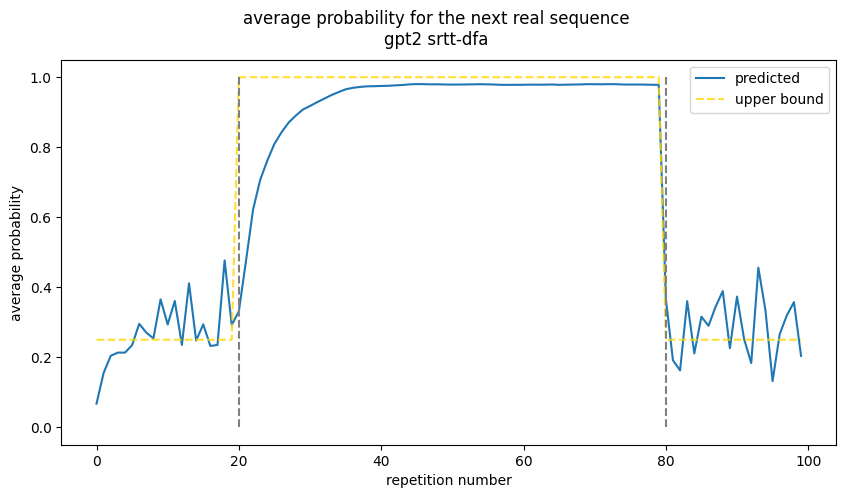

In [51]:
import matplotlib.pyplot as plt
import os

def draw_limit_dashes(ax, index_begin, index_end):
    ax.vlines(x=index_begin, ymin=0, ymax=1, linestyle="dashed", color='grey')
    ax.vlines(x=index_end, ymin=0, ymax=1, linestyle="dashed", color='grey')


def plot_sequence_probabilities(model_probs, random_epochs, learning_epochs,
                                model_name, dfa_type, label_probs):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(model_probs, label='predicted')
    ax.plot(label_probs, label='upper bound', linestyle='dashed', color='gold', alpha=0.8)
    draw_limit_dashes(ax, index_begin=random_epochs, index_end=learning_epochs+random_epochs)
    ax.legend()
    ax.set(xlabel="repetition number", ylabel="average probability")
    fig.suptitle(f"average probability for the next real sequence\n{model_name} {dfa_type}")
    out_dir = os.path.join("output", dfa_type)
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, f"per_sequence_{model_name}.png")
    fig.savefig(out_path)


plot_sequence_probabilities(avg_model_probs, NUM_RANDOM_EPOCHS, NUM_LEARNING_EPOCHS, model_name, f"srtt-dfa", avg_label_probs)